# **AI Project 1**
## **Surface Type Classification**

---

### Richanshu Jha - rj1469

## Importing Modules
* `pandas` and `numpy`: Pandas Dataframes are used here to store the datasets. Numpy is used along with this, numpy arrays are used which are very handy, allow useful array operations and work well with pandas dataframes
* `matplotlib.pyplot`: Used here for plotting graphs and plots.
* `sklearn.preprocessing`: `LabelEncoder` and `StandardScalar` are used for the preprocessing of data. Their use has been documented in detail at their respective cells. 
* `sklearn.metrics`: Its `accuracy_score` is used to generate accuracy. While it could easily be found using a custom accuracy function, I thought it would be better to use a universal function to do it.
* `seaborn` and `sklearn.metrics.confusion_matrix`: These are used twice in this notbook to create confusion matrices to better understand testing results.
* `sklearn.neural_network.MLPClassifier` and `sklearn.ensemble.RandomForestClassifier`: These are the two classifier that I have worked on in this notebook.
* `sklearn.model_selection.StratifiedKFold`: Used for cross-validation of the final model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

import seaborn as sn
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

## Importing the data from kaggle
* The dataset is loaded from Kaggle. X_train and y_train have been split into training and testing data according to the instructions provided in Slack.

In [2]:
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')

# split X_train
samples = 20
time_series = 128

start_x = X_train.shape[0] - samples*time_series
X_train_new, X_test_new = X_train.iloc[:start_x], X_train.iloc[start_x:]

# split y_train
start_y = y_train.shape[0] - samples
y_train_new, y_test_new = y_train.iloc[:start_y], y_train.iloc[start_y:]

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


## Approach
There are two ways of approaching this ML problem. We have time 128 series data points for each series. One thing that can be done is to disregard the time series entirely and perform model training without altering the size of the dataset. Another approach is that since data of time series is fairly similar, they can all be grouped together using aggregations. This allows for generation of a large number of relevant features if the correct aggregations are used. I have gone for this approach to solve the problem.

## Feature Engineering and Cleaning Data
The following has been done for engineering features for the model:
 1. Angular velocity and acceleration are given in X, Y ,Z. New features `velocityMagnitude` and `accelerationMagnitude` are created from these by getting the magnitude of their resultant vector.
 2. In order to create single values for each time series, the features have been grouped by the `series_id` and aggregates of the measurements has been considered. 
 3. Various statistical aggregates have been taken: 
     * The mean, median, min, max values are a good representation of the features.
     * Standard deviation and a 'max-min' (named `variation`) is a useful metric that should be able to separate surfaces based on their roughness.
     * Since this is a time series data, it is essential that we take the differences between pairs of subsequent measurements. To do this, the differences of the mean has been taken (`AbsMeanDelta`)
 4. After the training data is engineered, it has the number of rows equal to the number of `series_id` values. 
 5. Since the training data rows have effectivly been internally merged into the number of time series present, there is no need to expand the test set by 128. If the first discussed approach was followed, then this would have to be done 
 6. Features that were engineered that had very low importance scores have been removed. The final feature engineering results in 110 total features. 

In [3]:
xTrain = X_train_new
yTrain = y_train_new

xTest = X_test_new
yTest = y_test_new
    
def engineerFeats(inputDf):
    df = pd.DataFrame()
    
    featureCols = ['orientation_X', 'orientation_Y', 'orientation_Z', \
                   'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',   \
                   'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    #If we are not considering orientation features
    #featureCols = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', \
    #               'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
    
    inputDf['velocityMagnitude'] = ((inputDf['angular_velocity_X']**2) + (inputDf['angular_velocity_Y']**2) + (inputDf['angular_velocity_Z']**2)) ** 0.5
    featureCols.append('velocityMagnitude')
    
    inputDf['accelerationMagnitude'] = ((inputDf['linear_acceleration_X']**2) + (inputDf['linear_acceleration_Y']**2) + (inputDf['linear_acceleration_Z']**2)) ** 0.5
    featureCols.append('accelerationMagnitude')
        
    
    for col in featureCols:
        df[col + 'Min'] = inputDf.groupby('series_id')[col].min()
        df[col + 'Max'] = inputDf.groupby('series_id')[col].max()
        df[col + 'Mean'] = inputDf.groupby('series_id')[col].mean()
        df[col + 'Median'] = inputDf.groupby('series_id')[col].median()
        df[col + 'StdDev'] = inputDf.groupby('series_id')[col].std()
        df[col + 'q33'] = inputDf.groupby('series_id')[col].quantile(0.33)
        df[col + 'q66'] = inputDf.groupby('series_id')[col].quantile(0.66)
        df[col + 'q99'] = inputDf.groupby('series_id')[col].quantile(0.99)
        df[col + 'variation'] = inputDf.groupby('series_id')[col].max() \
                                - inputDf.groupby('series_id')[col].min()
        df[col + 'AbsMeanDelta'] = inputDf.groupby(['series_id'])[col] \
                                .apply(lambda x: np.mean(np.abs(np.diff(x))))
        
    #Cleaning the data
    df.fillna(0, inplace = True)
    df.replace(-np.inf, 0, inplace = True)
    df.replace(np.inf, 0, inplace = True)
    
    return(df)

print('Engineering features for Training dataset')
xTrain = engineerFeats(xTrain)

print('Engineering features for Testing dataset')
xTest = engineerFeats(xTest)

print('xTrain shape -> ',xTrain.shape)

print('xTest shape -> ',xTest.shape)
#print(xTest.head())

xTrain.head()

Engineering features for Training dataset


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Engineering features for Testing dataset
xTrain shape ->  (3790, 110)
xTest shape ->  (20, 110)


,orientation_XMin,orientation_XMax,orientation_XMean,orientation_XMedian,orientation_XStdDev,orientation_Xq33,orientation_Xq66,orientation_Xq99,orientation_Xvariation,orientation_XAbsMeanDelta,...,accelerationMagnitudeMin,accelerationMagnitudeMax,accelerationMagnitudeMean,accelerationMagnitudeMedian,accelerationMagnitudeStdDev,accelerationMagnitudeq33,accelerationMagnitudeq66,accelerationMagnitudeq99,accelerationMagnitudevariation,accelerationMagnitudeAbsMeanDelta
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.75953,-0.75822,-0.758666,-0.758530,0.000363,-0.758790,-0.758404,-0.758223,0.00131,0.000015,...,7.117152,12.575577,9.939676,10.077860,0.989642,9.568314,10.362028,12.001884,5.458424,0.689030
1,-0.95896,-0.95837,-0.958606,-0.958595,0.000151,-0.958670,-0.958530,-0.958380,0.00059,0.000023,...,5.867993,16.986332,10.082444,10.069950,1.826016,9.422569,10.708307,15.121862,11.118339,1.361058
2,-0.51434,-0.50944,-0.512057,-0.512035,0.001377,-0.512760,-0.511507,-0.509506,0.00490,0.000041,...,6.794325,12.725500,10.035741,10.082289,0.944637,9.592191,10.455842,12.191237,5.931175,0.711678
3,-0.93968,-0.93884,-0.939169,-0.939170,0.000227,-0.939320,-0.939042,-0.938850,0.00084,0.000026,...,2.064233,20.833299,10.888094,10.925683,3.102236,9.901812,11.796232,19.151114,18.769065,2.203234
4,-0.89689,-0.88673,-0.891301,-0.890940,0.002955,-0.892836,-0.889384,-0.886832,0.01016,0.000080,...,8.071708,11.485482,9.892815,10.005620,0.765162,9.446268,10.296655,11.379098,3.413774,0.521694


## Encoding Labels
* Here, `sklearn.preprocessing.LabelEncoder` is being used to label the categorical surface outputs. It essentially creates a hash mapping of each unique surface with an integer from 0 to n-1 (n being the number of unique surfaces. 
* Label Encoding is required so that the classifier gets discrete integers from 0 to 9 in order to classify properly.

In [4]:
labelEncoder = LabelEncoder()

labelEncoder.fit(yTrain['surface'])

yTrain['label'] = labelEncoder.transform(yTrain['surface'])
yTest['label'] = labelEncoder.transform(yTest['surface'])

yTrain.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


## Reviewing the Train and Test datasets
* This cell is primarily used for debugging.
* Note: The shape of the output dataframe is `(n,4)` because it stores `series_id`, `group_id`, `surface`, and the actual label: `label`. `DataFrame.label` will be passed as a numpy array to the model.

In [5]:
print('TRAINING FEATURES')
print('SHAPE: ',xTrain.shape)
#print(xTrain.head(), end='\n---------------\n')

print('\nTRAINING LABELS')
print('SHAPE: ',yTrain.shape)
#print(yTrain.head(), end='\n---------------\n')

print('\nTESTING FEATURES')
print('SHAPE: ',xTest.shape)
#print(xTest.head(), end='\n---------------\n')

print('\nTESTING LABELS')
print('SHAPE: ',yTest.shape)
#print(yTest.head(), end='\n---------------\n')

TRAINING FEATURES
SHAPE:  (3790, 110)

TRAINING LABELS
SHAPE:  (3790, 4)

TESTING FEATURES
SHAPE:  (20, 110)

TESTING LABELS
SHAPE:  (20, 4)


# Models
Models that were considered were `Logistic Regression`, `Support Vector Machines`, `Decision Trees`, `Random Forests`, `Deep Neural Networks` and `Convolutional Neural Networks`. Models that were implemented were optimized and tested, Logistic and Support vector machines were elimiated first. I tried building a convolutional neural network using tensorflow's `tflearn` module but kaggle experiences import errors when `import tflearn` is called, possibly due to version issues. 
# Neural Network
Scikit learn's Multi Layer Perceptron was used for the Neural network Implemenation. Initially, many models were made and tested on the same data. The parameters were left more or less constant and only the shape of the network was altered to find one that was giving the relatively best results. The `max_iterations` was initially set to 100, this was done to have it be feasible to test many different and complex networks. The final  2 to 3 layers, starting with 200 neurons in the first hidden layer, reducing by around half each layer. The `max_iterations` was gradually increased in subsequent tests while tuning the hyperparameters with small variations.

## Scaling
For a neural network, the data must be properly standardized. `sklearn.preprocessing.StandardScaler` is being used to scale it.

In [6]:
scaler = StandardScaler()

# FEATURE SCALING
scaler.fit(xTrain)
xTrainScaled = scaler.transform(xTrain)
xTestScaled = scaler.transform(xTest)

## Training

In [7]:
numLabels = len(yTrain.groupby('label').count())
print('Number of Labels: ', numLabels)

bSize = int(xTrain.shape[0]/6)
print('Batch Size: ', bSize)

hiddenLayersShape = (int(xTrain.shape[1]*2), int(xTrain.shape[1]*1), int(xTrain.shape[1]*0.5))
#hiddenLayersShape = (int(numLabels*numLabels), int(numLabels*numLabels/2))
print('Training Model with NN Hidden Layer Shape: ',hiddenLayersShape)

model = MLPClassifier(solver='adam', n_iter_no_change = 35, batch_size = bSize, max_iter = 1000 , hidden_layer_sizes=(hiddenLayersShape), activation = 'tanh', verbose = True)
model.fit(xTrainScaled, yTrain['label'])
print('Model Trained')

Number of Labels:  9
Batch Size:  631
Training Model with NN Hidden Layer Shape:  (220, 110, 55)
Iteration 1, loss = 1.97506933
Iteration 2, loss = 1.62350296
Iteration 3, loss = 1.56281711
Iteration 4, loss = 1.49413904
Iteration 5, loss = 1.43181758
Iteration 6, loss = 1.39121477
Iteration 7, loss = 1.35344931
Iteration 8, loss = 1.36805991
Iteration 9, loss = 1.34822521
Iteration 10, loss = 1.31681699
Iteration 11, loss = 1.29788612
Iteration 12, loss = 1.28237358
Iteration 13, loss = 1.26543547
Iteration 14, loss = 1.24050896
Iteration 15, loss = 1.21605044
Iteration 16, loss = 1.20362524
Iteration 17, loss = 1.20092919
Iteration 18, loss = 1.20276293
Iteration 19, loss = 1.20137665
Iteration 20, loss = 1.19597979
Iteration 21, loss = 1.16693841
Iteration 22, loss = 1.14185991
Iteration 23, loss = 1.12674523
Iteration 24, loss = 1.13658916
Iteration 25, loss = 1.11152147
Iteration 26, loss = 1.10488571
Iteration 27, loss = 1.09483360
Iteration 28, loss = 1.08255040
Iteration 29, lo

In [8]:
trueArr = np.array(yTrain['label'])
predArr = model.predict(xTrainScaled)

trainingAccuracy = metrics.accuracy_score(trueArr, predArr)
print('Training Accuracy: ',trainingAccuracy)

Training Accuracy:  0.9469656992084433


## Testing Accuracy 
This model was tested with the 20 sample `y_test_new` and had a high variance in scores. The score ranged from `0.85` to `0.95`. The corrosponding confusion matrix has been plotted.

Testing Acuracy 0.85


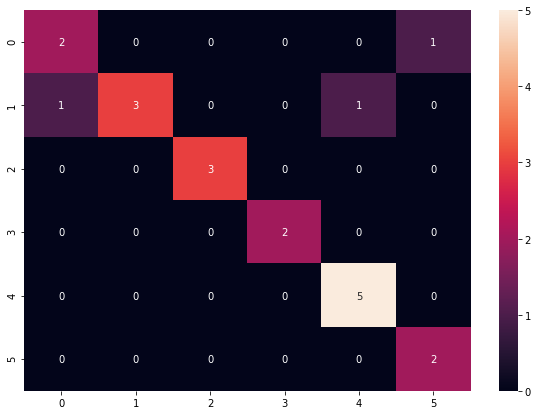

In [9]:
trueArr = np.array(yTest['label'])
predArr = model.predict(xTestScaled)

testingAccuracy = metrics.accuracy_score(trueArr, predArr)
'''
print('Confusion Matrix: \n')
print(confusion_matrix(predArr,trueArr))
print('\n')
print('Number of test samples: ',len(trueArr))
'''
print('Testing Acuracy', testingAccuracy)

dfConfusionMat = pd.DataFrame(confusion_matrix(predArr, trueArr))
plt.figure(figsize = (10,7))
sn.heatmap(dfConfusionMat, annot=True)

# Random Forest Classifier
Scikit learn's `RandomForestClassifier` has been used for getting a more reliable classification. It has been consitently giving a low variance in the training and testing accuracies, with a lower difference in training and testing accuracy than the Neural Network.

## Training the Model

In [10]:
#model = RandomForestClassifier(n_estimators = 100, verbose = 2, max_depth = 25)
model = RandomForestClassifier(n_estimators = 600, max_depth = 25 ,n_jobs = -1, verbose = 2)

model.fit(xTrain, yTrain['label'])
print('Model Trained')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600building tree 6 of 600

building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600building tree 15 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600building tree 22 of 600

building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600building tree 30 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.5s


building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600building tree 58 of 600

building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 66 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 71 of 600
building tree 72 of 600
building tree 73 of 600
building tree 74 of 600
building tree 75 of 600
building tree 76 of 600
building tree 77 of 600
building tree 78 of 600
building tree 79 of 600
building tree 80 of 600
building tree 81 of 600
building tree 82 of 600
building tree 83 of 600
building tree 84 of 600
building tree 85 of 600
building tree 86 of 600
building tree 87 of 600
building tree 88 of 600
building tree 89 of 600
building tree 90

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    2.2s


building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600building tree 175 of 600

building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600building tree 185 of 600
building tree 186 of 600

building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600building tree 195 of 600

building tree 196 of 600
building tree 197 of 600
building tree 198 of 600
building tree 199 of 600


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    5.0s


building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600building tree 375 of 600

building tree 376 of 600
building tree 377 of 600
building tree 378 of 600building tree 379 of 600

building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600building tree 390 of 600

building tree 391 of 600
building tree 392 of 600
building tree 393 of 600
building tree 394 of 600
building tree 395 of 600
building tree 396 of 600
building tree 397 of 600
building tree 398 of 600
building tree 399 of 600
building tree 400 of 600
building tree 401 of 600
building tree 402 of 600
building tree 403 of 600
building tree 404 of 600
building tree 405 of 600
building tree 406 of 600
building tree 407 of 600
building tree 408 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    8.3s finished


## Plotting important features
Feature importance from this has been the main metric of selecting and engineering features at the start of this notebook

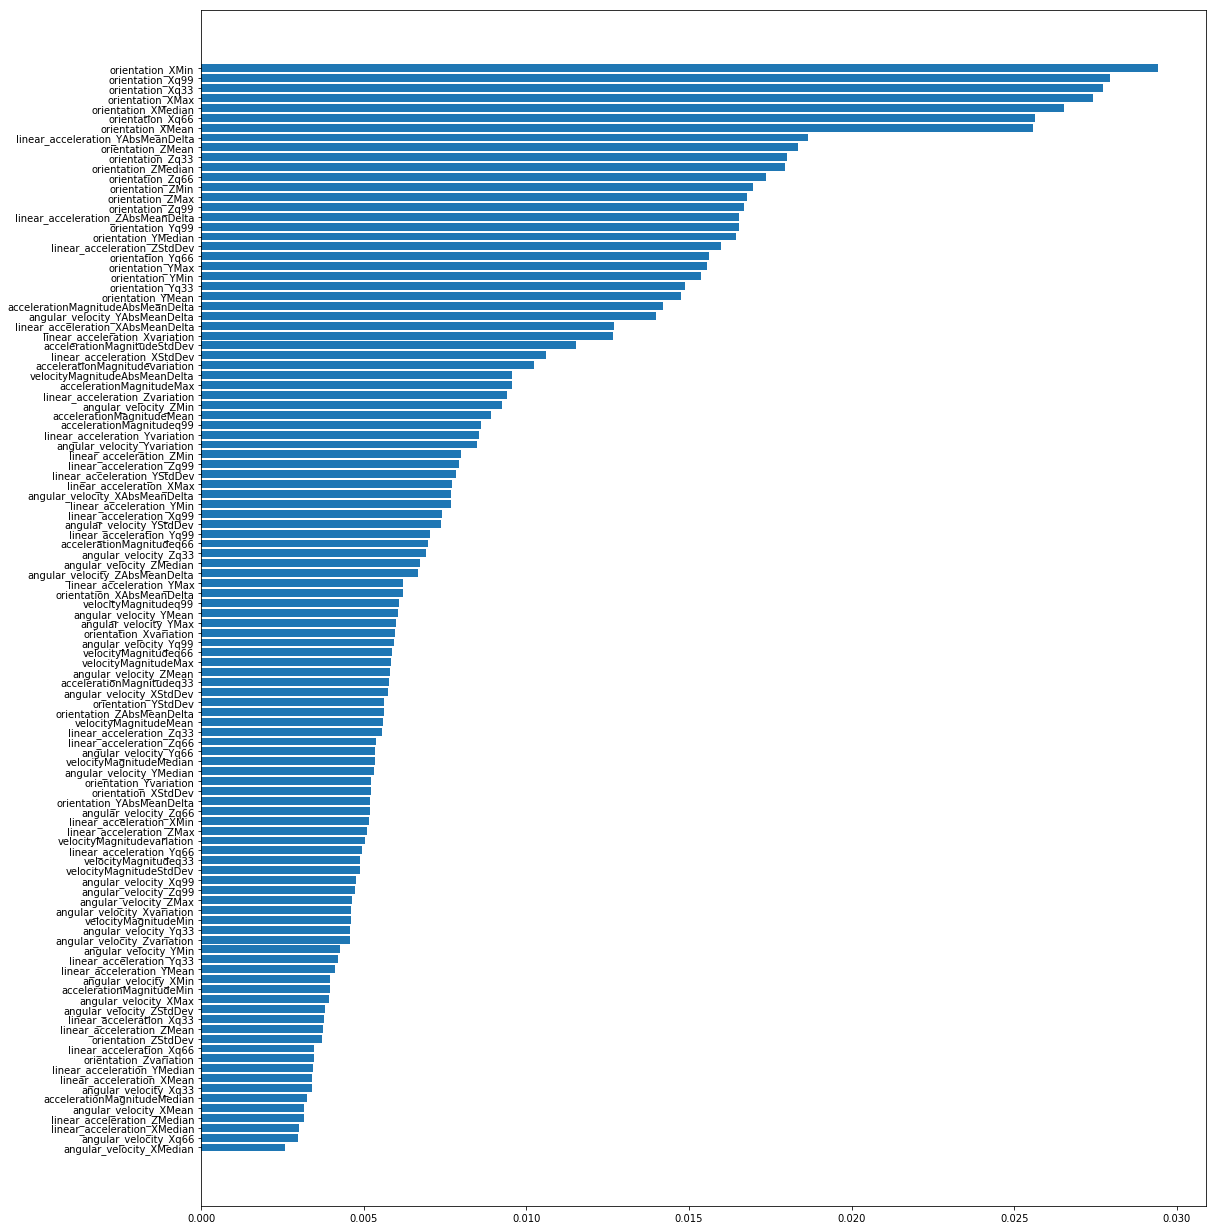

In [11]:
### PLOTTING
df = pd.DataFrame()
df['x'] = [col for col in xTrain]
df['y'] = model.feature_importances_
df = df.sort_values(by = ['y'])

fig=plt.figure(figsize=(18, df.shape[0]/5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.barh(df['x'],df['y'],0.8)
plt.show()

## Testing Accuracy
This model was tested with the 20 sample `y_test_new` and is consitent with the scores. This model generally scores `0.95` on the given test data. While comparing this with the neural network, larger data samples were tested, The neural network sometimes gets a better testing accuracy than this; however it has unreliable amount of varation in accuracies even with the same hyperparameters. Due to this, the Random Forest model has been selected for this project. 

The confusion matrix corrosponding to the 20 sample test has been plotted.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    0.2s finished


Testing Acuracy 0.95


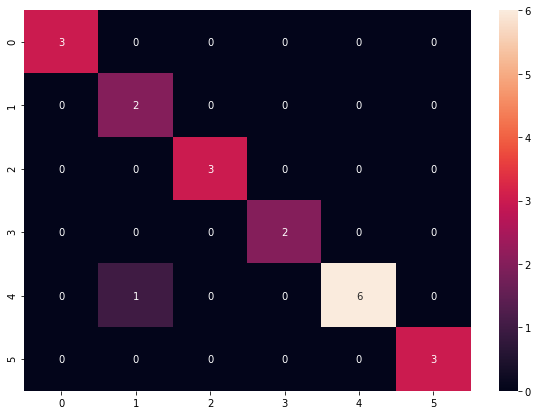

In [12]:
trueArr = np.array(yTest['label'])
predArr = model.predict(xTest)

testingAccuracy = metrics.accuracy_score(trueArr, predArr)

'''
print('Confusion Matrix: \n')
print(confusion_matrix(predArr, trueArr))
print('\n')
print('Number of test samples: ',len(trueArr))
'''
print('Testing Acuracy', testingAccuracy)

dfConfusionMat = pd.DataFrame(confusion_matrix(predArr, trueArr))
plt.figure(figsize = (10,7))
sn.heatmap(dfConfusionMat, annot=True)

## Stratified K Fold Cross validation
K-Fold crossvalidation iteratively takes k sections of the dataset to test and train the model. Stratified K-Fold tries to ensure that the ratio of classes in the dataset and subsets of the datasets remains even. This method gives a much less biased value for the accuracy of the model.

#### **PLEASE NOTE** : This Algorithm for Stratified K-Fold Cross validation, while present in some or complete part in most notebooks, has been been directly referred to from https://www.kaggle.com/gpreda/robots-need-help

In [13]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

sub_preds_rf = np.zeros((xTest.shape[0], 9))
oof_preds_rf = np.zeros((xTrain.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(xTrain, yTrain['label'])):
    #clf =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
    clf = RandomForestClassifier(n_estimators = 200 ,n_jobs = -1, verbose = 0)
    clf.fit(xTrain.iloc[trn_idx], yTrain['label'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(xTrain.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(xTest) / folds.n_splits
    score += clf.score(xTrain.iloc[val_idx], yTrain['label'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(xTrain.iloc[val_idx], yTrain['label'][val_idx])))
    
print('\nAvg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.8707124010554089
Fold: 1 score: 0.9182058047493403
Fold: 2 score: 0.8601583113456465
Fold: 3 score: 0.8733509234828496
Fold: 4 score: 0.8522427440633246
Fold: 5 score: 0.8891820580474934
Fold: 6 score: 0.8944591029023746
Fold: 7 score: 0.8970976253298153
Fold: 8 score: 0.8812664907651715
Fold: 9 score: 0.8522427440633246

Avg Accuracy 0.878891820580475


## Conclusion
To conclude, two models have been developed for this project. The neural network model could be optimized furhter but as it currently stands, the Random Forest is providing a better classification and thus its scores are going to be reported

## Final Scores

* With K-Fold CrossValidation: ~88%
* Accuracy of sample `y_test_new`: 95% (19/20 samples)